<a href="https://colab.research.google.com/github/dlskawns/cp1/blob/main/4_cohort_customers_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. 문맥을 통한 고객 집단 분류 모델  


## Transformer - Bert(bert-base-uncased)를 이용 
반려동물용 상품을 판매하는 것이 파악되어 반려동물 유무(0 - 없음, 1 - 강아지, 2 - 고양이, 3 - 강아지와 고양이)로 고객 세분화 진행

### * 선정 이유:  
label(반려동물 유무 여부)을 설정한 뒤, 전체 문맥에 따른 특징적인 패턴을 찾아 전체 데이터셋에 자동으로 label을 지정하기 위함.  
ㄴ> 이를 통해 궁극적으로 고객의 집단은 분류하는 feature를 생성.


### * 가설:  
BERT를 이용해 문맥데이터와 label을 학습하면 문장들의 패턴을 파악해 반려동물 유무에 대한 고객 세분화가 가능할 것이다.


### * 방법:  
  * 리뷰 내에서 dog, cat을 파악할 수 있는 키워드를 통해 일차적으로 label 생성
  * label 분포 파악 후 imbalanced 할 경우, under sampling 및 SMOTE 진행 후 성능 파악
  * 샘플링 방법 선정 후(최종-under sampling) BERT 다중분류 모델 학습 진행 
  * 학습 완료된 모델을 통해 자동 라벨링 진행

  <br>

  ---

### 반려동물(dog, cat)을 키우는 고객 여부 파악. 1차 키워드 분류

dog과 cat의 여부를 파악할 수 있는 words를 포함하고 있다면, 각각의 label을 부여한다.  
(No: 0, dog: 1, cat: 2, both: 3)

In [ ]:
# Text에서 고객 파악
def sorting_labels(df):
  labels = []
  for i in df['Text']:
    i = i.lower()
    if ('my dog' in i) and ('my cat' in i):
      labels.append(3)
    elif ('my dog' in i):
      labels.append(1)
    elif ('my cat' in i):
      labels.append(2)
    elif (('tasty' in i) or  ('taste good' in i) or ('yummy' in i)) and (('dog' not in i) or ('cat' not in i) or ('puppy' not in i)):
      labels.append(0)
    else:
      labels.append(None)
  df['labels'] = labels
  return df

In [ ]:
# summary에서 고객파악
def sorting_hints(df):
  labels = []
  for i, k in zip(df['Summary'], range(len(df['labels']))):
    i = i.lower()
    if pd.isna(df['labels'][k])==True:
      if ('dog' in i) and ('cat' in i):
        df['labels'][k] = 3
      elif ('dog' in i ):
        df['labels'][k] = 1
      elif ('cat' in i ):
        df['labels'][k] = 2
      elif (('tasty' in i ) or  ('taste good' in i ) or ('yummy' in i )) and (('dog' not in i ) or ('cat' not in i ) or ('puppy' not in i )):
        df['labels'][k] = 0
    else:
      continue
  return df

In [ ]:
sorting_labels(df)
sorting_hints(df)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,dayofweek,r_counts,keyword,labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,Wednesday,1,"['vitality', 'finicky', 'smells', 'labrador', ...",1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,Friday,1,"['jumbo', 'unsalted', 'small', 'sized', 'vendo...",NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,Monday,3,"['gelatin', 'pillowy', 'mouthful', 'coated', '...",0.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,Monday,3,"['medicinal', 'robitussin', 'cherry', 'ingredi...",NaN
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,Sunday,2,"['quick', 'wide', 'delivery', 'deal', 'lover']",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,2011-03-09,Wednesday,1,"['sesame', 'chicken', 'husband', 'recipes', 'r...",NaN
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,2012-03-09,Friday,9,"['notes', 'small', 'thanks', 'weak', 'disappoi...",NaN
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012-02-21,Tuesday,1,"['compare', 'train', 'smell', 'preservatives',...",NaN
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012-03-13,Tuesday,2,"['rewarding', 'grooming', 'sweet', 'wet', 'tre...",NaN


In [ ]:
# 라벨 분포 => 3 (둘 다 있는 경우의 라벨이 매우 적다.)
df['labels'].value_counts()

0.0    52211
1.0    35806
2.0    17439
3.0      430
Name: labels, dtype: int64

In [ ]:
#######
######## 텍스트에 dog or cat이 없더라도 Summary에 있는 경우 캐치한다.

df_bert= df[(((df['Summary'].str.contains('dog')) |
    (df['Summary'].str.contains('Dog')) |
    (df['Summary'].str.contains('DOG'))) &
    ~((df['Text'].str.contains('dog')) |
    (df['Text'].str.contains('Dog')) |
    (df['Text'].str.contains('DOG')))) |

    (((df['Summary'].str.contains('cat')) |
    (df['Summary'].str.contains('Cat')) |
    (df['Summary'].str.contains('CAT'))) &
    ~((df['Text'].str.contains('cat')) |
    (df['Text'].str.contains('Cat')) |
    (df['Text'].str.contains('CAT')))) |

    ((df['labels']== 0) &
    ~((df['Text'].str.contains('cat')) |
    (df['Text'].str.contains('Cat')) |
    (df['Text'].str.contains('CAT')) |
    (df['Text'].str.contains('dog')) |
    (df['Text'].str.contains('Dog')) |
    (df['Text'].str.contains('DOG')))) |
    
    (df['labels']==3)]


In [ ]:
df['labels'].value_counts()

0.0    39068
1.0    35785
2.0    17465
3.0      420
Name: labels, dtype: int64

In [ ]:
df_bert['labels'].value_counts()

0.0    37109
1.0     2811
2.0      962
3.0      420
Name: labels, dtype: int64

### 반려동물(dog, cat)을 키우는 고객 여부 파악. 2차 BERT를 이용한 분류

dog과 cat의 여부를 파악할 수 있는 words를 포함하고 있다면, 각각의 label을 부여한다.  
(No: 0, dog: 1, cat: 2, both: 3)

#### Tokenizer 작성 

모델 입력에 이용할 BertTokenizer를 작성합니다. 

In [ ]:

# Config 설적을 통해 Bert base 모델 가져오기
config = BertConfig.from_pretrained('bert-base-uncased')
config.output_hidden_states = False

# 토크나이저 정의 - Config를 일치시켜 같은 모델에 대한 토크나이저를 가져오기
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = 'bert-base-uncased', config = config)

# Bert 모델 가져오기
transformer_model = TFBertModel.from_pretrained('bert-base-uncased', config = config)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### Model Architecture 작성


In [ ]:
bert = transformer_model.layers[0]
input_ids = tf.keras.Input(shape = (128, ), name = 'input_ids', dtype = 'int32')
inputs = {'input':input_ids}
bert_model = bert(input_ids)[1]
dropout = Dropout(config.hidden_dropout_prob, name = 'pooled_output')
pooled_output = dropout(bert_model, training=False)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=config.initializer_range), name = 'output')(pooled_output)
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Bert_Classifier')
model.summary()

Model: "Bert_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 128)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             128, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

#### Under Sampling

고양이와 강아지 모두 키우는 사람이 수가 적으므로 해당 수에 맞춰서 학습시킨다.

In [ ]:
df_bert_1 = df_bert[df_bert['labels']==1][:300]
df_bert_2 = df_bert[df_bert['labels']==2][:300]
df_bert_0 = df_bert[df_bert['labels']==0][:300]
df_bert_3 = df_bert[df_bert['labels']==3][:300]
df_bert_train = pd.concat([df_bert_1,df_bert_2,df_bert_3,df_bert_0])
df_bert_train = df_bert_train.sample(frac=1)

In [ ]:
df_bert_11 = df_bert[df_bert['labels']==1][300:420]
df_bert_22 = df_bert[df_bert['labels']==2][300:420]
df_bert_00 = df_bert[df_bert['labels']==0][300:420]
df_bert_33 = df_bert[df_bert['labels']==3][300:420]
df_bert_val = pd.concat([df_bert_11,df_bert_22,df_bert_33,df_bert_00])
df_bert_val = df_bert_val.sample(frac=1)

In [ ]:
df_bert_111 = df_bert[df_bert['labels']==1][420:5420]
df_bert_222 = df_bert[df_bert['labels']==2][420:5420]
df_bert_000 = df_bert[df_bert['labels']==0][420:5420]
# df_bert_33 = df_bert[df_bert['labels']==3][420:5420]
df_bert_test = pd.concat([df_bert_111,df_bert_222,df_bert_000])
df_bert_test = df_bert_test.sample(frac=1)

In [ ]:
df[df['labels'].notnull()]['labels'].value_counts()

0.0    39068
1.0    35785
2.0    17465
3.0      420
Name: labels, dtype: int64

In [ ]:
%%time

optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-05,
                                     epsilon=1e-08,
                                     decay=0.01,
                                     clipnorm=1.0)
loss = 'sparse_categorical_crossentropy'
metric = ['accuracy']

model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x= tokenizer(
    text = df_bert_train['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
     
)

early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights= True)


history = model.fit(x['input_ids'],df_bert_train['labels'], validation_split=0.2, batch_size = 64, epochs=10, callbacks=[early])

Epoch 1/10
15/15 [==============================] - 32s 1s/step - loss: 1.3387 - accuracy: 0.3406 - val_loss: 1.3053 - val_accuracy: 0.3958
Epoch 2/10
15/15 [==============================] - 14s 972ms/step - loss: 1.2403 - accuracy: 0.4219 - val_loss: 1.1563 - val_accuracy: 0.4917
Epoch 3/10
15/15 [==============================] - 14s 972ms/step - loss: 0.9695 - accuracy: 0.5698 - val_loss: 0.7455 - val_accuracy: 0.6917
Epoch 4/10
15/15 [==============================] - 14s 973ms/step - loss: 0.6197 - accuracy: 0.7635 - val_loss: 0.4728 - val_accuracy: 0.8417
Epoch 5/10
15/15 [==============================] - 14s 973ms/step - loss: 0.3886 - accuracy: 0.8823 - val_loss: 0.4667 - val_accuracy: 0.8167
Epoch 6/10
15/15 [==============================] - 14s 973ms/step - loss: 0.2298 - accuracy: 0.9406 - val_loss: 0.4369 - val_accuracy: 0.8458
Epoch 7/10
15/15 [==============================] - 14s 953ms/step - loss: 0.1198 - accuracy: 0.9792 - val_loss: 0.4439 - val_accuracy: 0.8458
Ep

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
x1= tokenizer(
    text = df_bert_val['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
)

pred = model.predict(x1['input_ids'])
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(df_bert_val['labels'],pred_result)))
# print("f1_score \n",f1_score(df_bert_val['labels'],pred_result))
print("confusion matrix \n",confusion_matrix(df_bert_val['labels'],pred_result))
print('classification report \n', classification_report(df_bert_val['labels'], pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.890
confusion matrix 
 [[111   0   9   0]
 [  1 108   9   2]
 [ 13  13  90   4]
 [  0   1   1 118]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.89      0.93      0.91       120
       1 강아지       0.89      0.90      0.89       120
       2 고양이       0.83      0.75      0.79       120
 3 강아지 + 고양이       0.95      0.98      0.97       120

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480



#### 재학습

In [ ]:
df_bert_1111 = df[df['labels']==1][:10000]
df_bert_2222 = df[df['labels']==2][:10000]
df_bert_0000 = df[df['labels']==0][:10000]
# df_bert_3 = df[df['labels']==3][:300]
df_bert_train2 = pd.concat([df_bert_1111,df_bert_2222,df_bert_0000])
df_bert_train2 = df_bert_train2.sample(frac=1)

In [ ]:
df_bert_11111 = df[df['labels']==1][10000:]
df_bert_22222 = df[df['labels']==2][10000:]
df_bert_00000 = df[df['labels']==0][10000:]
df_bert_33333 = df[df['labels']==3]
df_bert_test2 = pd.concat([df_bert_11111,df_bert_22222,df_bert_33333,df_bert_00000])
df_bert_test2 = df_bert_test2.sample(frac=1)

In [ ]:
%%time

optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-05,
                                     epsilon=1e-08,
                                     decay=0.01,
                                     clipnorm=1.0)
loss = 'sparse_categorical_crossentropy'
metric = ['accuracy']

model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x2= tokenizer(
    text = df_bert_train2['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
     
)

early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights= True)


history = model.fit(x2['input_ids'],df_bert_train2['labels'], validation_split=0.2, batch_size = 64, initial_epoch= history.epoch[-1], epochs=20, callbacks=[early])

Epoch 9/20
375/375 [==============================] - 371s 953ms/step - loss: 0.1222 - accuracy: 0.9625 - val_loss: 0.0831 - val_accuracy: 0.9780
Epoch 10/20
375/375 [==============================] - 354s 944ms/step - loss: 0.0569 - accuracy: 0.9841 - val_loss: 0.0732 - val_accuracy: 0.9810
Epoch 11/20
375/375 [==============================] - 353s 943ms/step - loss: 0.0396 - accuracy: 0.9893 - val_loss: 0.0742 - val_accuracy: 0.9813
Epoch 12/20
375/375 [==============================] - 354s 943ms/step - loss: 0.0293 - accuracy: 0.9934 - val_loss: 0.0708 - val_accuracy: 0.9817
Epoch 13/20
375/375 [==============================] - 353s 942ms/step - loss: 0.0227 - accuracy: 0.9947 - val_loss: 0.0725 - val_accuracy: 0.9827
Epoch 14/20
375/375 [==============================] - 353s 943ms/step - loss: 0.0186 - accuracy: 0.9959 - val_loss: 0.0774 - val_accuracy: 0.9827
Epoch 15/20
375/375 [==============================] - 354s 943ms/step - loss: 0.0153 - accuracy: 0.9968 - val_loss: 0.

#### 과적합일 수 있으므로 불균형 대용량 테스트셋 생성

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
X= tokenizer(
    text = df_bert_test2['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
)

pred = model.predict(X['input_ids'])
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(df_bert_test2['labels'],pred_result)))
# print("f1_score \n",f1_score(df_bert_test2['labels'],pred_result))
print("confusion matrix \n",confusion_matrix(df_bert_test2['labels'],pred_result))
print('classification report \n', classification_report(df_bert_test2['labels'], pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.974
confusion matrix 
 [[28485   174   409     0]
 [  215 25408   162     0]
 [  178    54  7233     0]
 [    1   179   240     0]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.99      0.98      0.98     29068
       1 강아지       0.98      0.99      0.98     25785
       2 고양이       0.90      0.97      0.93      7465
 3 강아지 + 고양이       0.00      0.00      0.00       420

    accuracy                           0.97     62738
   macro avg       0.72      0.73      0.73     62738
weighted avg       0.97      0.97      0.97     62738



#### SMOTE를 통한 Over Sampling

K-MEANS 군집화를 이용해 군집 내 랜덤 샘플 생성

In [ ]:
df_bert['labels'].value_counts()

0.0    37109
1.0     2811
2.0      962
3.0      420
Name: labels, dtype: int64

In [ ]:
df_bert_1 = df_bert[df_bert['labels']==1][:800]
df_bert_2 = df_bert[df_bert['labels']==2][:800]
df_bert_0 = df_bert[df_bert['labels']==0][:800]
df_bert_3 = df_bert[df_bert['labels']==3][:300]
df_bert_train1 = pd.concat([df_bert_1,df_bert_2,df_bert_3,df_bert_0])
df_bert_train1 = df_bert_train1.sample(frac=1)

In [ ]:
df_bert_11 = df_bert[df_bert['labels']==1][800:920]
df_bert_22 = df_bert[df_bert['labels']==2][800:920]
df_bert_00 = df_bert[df_bert['labels']==0][800:920]
df_bert_33 = df_bert[df_bert['labels']==3][300:420]
df_bert_val1 = pd.concat([df_bert_11,df_bert_22,df_bert_33,df_bert_00])
df_bert_val1 = df_bert_val1.sample(frac=1)

In [ ]:
df_bert_train1.drop(columns=['ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator','date', 'keyword'], inplace = True)
df_bert_val1.drop(columns=['ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator','date', 'keyword'], inplace = True)

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder

def berttok(df, col):

  df[col]= np.array(tokenizer(
      text = df[col].to_list(),
      add_special_tokens=True,
      max_length = 128,
      truncation = True,
      padding = True,
      # return_tensors='tf',
      return_token_type_ids=False,
      # returen_attention_mask=False,
      verbose = True)['input_ids'])

text = 'Text'
summary = 'Summary'
berttok(df_bert_train1, text)
berttok(df_bert_train1, summary)
berttok(df_bert_val1, text)
berttok(df_bert_val1, summary)

encoder = OrdinalEncoder(cols=['ProductId','UserId','dayofweek'])
bert_train_encoded = encoder.fit_transform(df_bert_train1)
bert_val_encoded = encoder.transform(df_bert_val1)

scaler = StandardScaler()
bert_train_scaled = scaler.fit_transform(bert_train_encoded)
bert_val_scaled = scaler.transform(bert_val_encoded)


pca = PCA(n_components = 2)           # 2차원으로 시각화를 진행할 것이므로 2개로 설정한다.
pca.fit(bert_train_scaled)             
df_p = pca.transform(bert_train_scaled)
df_p = pd.DataFrame(df_p, columns = ['PC1','PC2']) #PCA진행 한 두 개의 값을 column으로 데이터프레임화 시킨다.
df_p

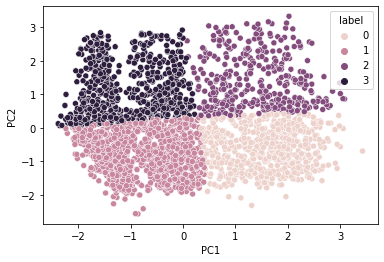

In [ ]:
# 군집 시각화
sns.scatterplot(data = df_p, x = 'PC1',y = 'PC2', hue = 'label'); 

In [ ]:
# SMOTE 진행
smote = BorderlineSMOTE()
data,label = smote.fit_resample(df_p, labels)

In [ ]:
# %%time

bert = transformer_model.layers[0]
input_ids = tf.keras.Input(shape = (10, ), name = 'input_ids', dtype = 'int32')
inputs = {'input':input_ids}
bert_model = bert(input_ids)[1]
dropout = Dropout(config.hidden_dropout_prob, name = 'pooled_output')
pooled_output = dropout(bert_model, training=False)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=config.initializer_range), name = 'output')(pooled_output)
model1= tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Bert_Classifier')
model1.summary()


optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-05,
                                     epsilon=1e-08,
                                     decay=0.01,
                                     clipnorm=1.0)
loss = 'sparse_categorical_crossentropy'
metric = ['accuracy']

model1.compile(optimizer = optimizer, loss = loss, metrics = metric)

early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights= True)



Model: "Bert_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 128)]             0         
                                                                 
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 pooled_output (Dropout)     (None, 768)               0         
                                                                 
 output (Dense)              (None, 4)                 3076      
                                                                 
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model1.fit(data,label, validation_split=0.2, batch_size = 64, epochs=10, callbacks=[early])

#### Scaling 하지 않고 SMOTE 진행

In [ ]:
x3= tokenizer(
  text = df_bert_train1['Text'].to_list(),
  add_special_tokens=True,
  max_length = 128,
  truncation = True,
  padding = True,
  return_tensors='tf',
  return_token_type_ids=False,
  # returen_attention_mask=False,
  verbose = True)['input_ids']


In [ ]:
kmeans = KMeans().fit(x3)
labels = kmeans.predict(x3)
smote = BorderlineSMOTE()
data,label = smote.fit_resample(x3,df_bert_train1['labels'])

In [ ]:
bert = transformer_model.layers[0]
input_ids = tf.keras.Input(shape = (128, ), name = 'input_ids', dtype = 'int32')
inputs = {'input':input_ids}
bert_model = bert(input_ids)[1]
dropout = Dropout(config.hidden_dropout_prob, name = 'pooled_output')
pooled_output = dropout(bert_model, training=False)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=config.initializer_range), name = 'output')(pooled_output)
model2= tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Bert_Classifier')
model2.summary()


optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-06,
                                     epsilon=1e-08,
                                     decay=0.01,
                                     clipnorm=1.0)
loss = 'sparse_categorical_crossentropy'
metric = ['accuracy']

early = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', patience= 3)

model2.compile(optimizer = optimizer, loss = loss, metrics = metric)

Model: "Bert_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 128)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             128, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

In [ ]:
model2.fit(data,label, validation_split=0.2, batch_size = 64, epochs=10, callbacks=[early])

Epoch 1/10
40/40 [==============================] - 58s 991ms/step - loss: 1.1316 - accuracy: 0.6559 - val_loss: 1.5027 - val_accuracy: 0.4766
Epoch 2/10
40/40 [==============================] - 37s 936ms/step - loss: 0.6938 - accuracy: 0.9219 - val_loss: 1.5424 - val_accuracy: 0.4703
Epoch 3/10
40/40 [==============================] - 37s 936ms/step - loss: 0.4960 - accuracy: 0.9324 - val_loss: 1.5888 - val_accuracy: 0.4766
Epoch 4/10
40/40 [==============================] - 40s 1000ms/step - loss: 0.3835 - accuracy: 0.9461 - val_loss: 1.6445 - val_accuracy: 0.4766


In [ ]:
x4= tokenizer(
text = df_bert_val1['Text'].to_list(),
add_special_tokens=True,
max_length = 128,
truncation = True,
padding = True,
return_tensors='tf',
return_token_type_ids=False,
# returen_attention_mask=False,
verbose = True)['input_ids']

kmeans = KMeans().fit(x4)
labels = kmeans.predict(x4)
smote = BorderlineSMOTE()
data,label = smote.fit_resample(x4, df_bert_val1['labels'])

model2.evaluate(x4, df_bert_val1)

15/15 [==============================] - 4s 146ms/step - loss: 0.4508 - accuracy: 0.8896


[0.4508122503757477, 0.8895833492279053]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

pred = model2.predict(data)
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(label,pred_result)))
# print("f1_score \n",f1_score(label,pred_result))
print("confusion matrix \n",confusion_matrix(label,pred_result))
print('classification report \n', classification_report(label, pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.890
confusion matrix 
 [[100   3  17   0]
 [  1 108   9   2]
 [  8   5 102   5]
 [  1   1   1 117]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.91      0.83      0.87       120
       1 강아지       0.92      0.90      0.91       120
       2 고양이       0.79      0.85      0.82       120
 3 강아지 + 고양이       0.94      0.97      0.96       120

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

pred = model2.predict(x4)
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(df_bert_val1['labels'],pred_result)))
# print("f1_score \n",f1_score(df_bert_val1['labels'],pred_result))
print("confusion matrix \n",confusion_matrix(df_bert_val1['labels'],pred_result))
print('classification report \n', classification_report(df_bert_val1['labels'], pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.890
confusion matrix 
 [[100   3  17   0]
 [  1 108   9   2]
 [  8   5 102   5]
 [  1   1   1 117]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.91      0.83      0.87       120
       1 강아지       0.92      0.90      0.91       120
       2 고양이       0.79      0.85      0.82       120
 3 강아지 + 고양이       0.94      0.97      0.96       120

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480



#### 최종 SMOTE test셋 검증

In [ ]:
df_bert_test = df.drop(index= df_bert['Id'].index)

In [ ]:
df['labels'].value_counts()

0.0    39068
1.0    35785
2.0    17465
3.0      420
Name: labels, dtype: int64

In [ ]:
df_bert_111 = df_bert_test[df_bert_test['labels']==1][:10000]
df_bert_222 = df_bert_test[df_bert_test['labels']==2][:10000]
df_bert_000 = df_bert_test[df_bert_test['labels']==0][:10000]
# df_bert_33 = df_bert_test[df_bert_test['labels']==3][300:420]
df_bert_test1 = pd.concat([df_bert_111,df_bert_222,df_bert_000])
df_bert_test1 = df_bert_test1.sample(frac=1)

In [ ]:
x5= tokenizer(
text = df_bert_test1['Text'].to_list(),
add_special_tokens=True,
max_length = 128,
truncation = True,
padding = True,
return_tensors='tf',
return_token_type_ids=False,
# returen_attention_mask=False,
verbose = True)['input_ids']


model2.evaluate(x5, df_bert_test1['labels'])

687/687 [==============================] - 119s 169ms/step - loss: 1.9562 - accuracy: 0.1402


[1.9561833143234253, 0.14021585881710052]

In [ ]:
pred = model2.predict(x5)
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(df_bert_test1['labels'],pred_result)))
# print("f1_score \n",f1_score(df_bert_test1['labels'],pred_result))
print("confusion matrix \n",confusion_matrix(df_bert_test1['labels'],pred_result))
print('classification report \n', classification_report(df_bert_test1['labels'], pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.140
confusion matrix 
 [[1376   20  285  278]
 [ 117  223   96 9564]
 [ 195   42 1480 8283]
 [   0    0    0    0]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.82      0.70      0.75      1959
       1 강아지       0.78      0.02      0.04     10000
       2 고양이       0.80      0.15      0.25     10000
 3 강아지 + 고양이       0.00      0.00      0.00         0

    accuracy                           0.14     21959
   macro avg       0.60      0.22      0.26     21959
weighted avg       0.79      0.14      0.20     21959



### 최종 카테고리 분류 진행

위에서 학습한 내용으로 예측을 하여 자동으로 반려동물 유무 카테고리 라벨링을 한다.

In [ ]:
X_df= tokenizer(
    text = df['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
)
pred_df = model.predict(X_df['input_ids'])
pred_result_df = [np.argmax(pred_df[i]) for i in range(len(pred_df))]


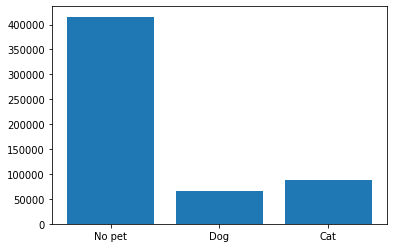

In [ ]:
plt.bar(df['pet'].value_counts().index, df['pet'].value_counts().values)
plt.xticks(df['pet'].value_counts().index, ['No pet','Cat','Dog'])
plt.show();


In [ ]:
df['pet'].value_counts()

0    415653
2     87166
1     65635
Name: pet, dtype: int64

### * 문맥을 통한 고객 집단 분류모델 학습 결과:  
  * 학습시 under sampling이 SMOTE보다 성능이 좋으며, accuracy 90% 이상의 준수한 성능을 보임
  * 모델 predict를 통해 자동으로 라벨링 작업을 진행할 수 있음 




### * 문제 및 개선점:
  * 1차 학습시 86%, 2차 학습시 95% 성능을 보였지만, 강아지와 고양이 둘 다 키우는 고객을 분류하는 작업은 accuracy 0으로 전혀 분류진행이 되지 않음. 초기 학습때 undersampling을 했지만, 1(dog)과 2(cat)에 대한 패턴과 상당히 유사해 그 차이를 파악하지 못한것으로 파악.
    - 3번 카테고리를 없애거나 카테고리를 통합해 지도학습 진행 시 학습량 자체를 높여야 한다.
    
  * 1차 키워드 추출시에는 고양이관련 고객이 강아지관련 유저보다 적었지만, 2차 추출 모델링 이후엔 고양이 관련 유저가 급격히 늘게 됨  
  * 고양이를 키우지 않는 많은 고객들에게 추천할 확률이 높으므로 개선 필요:

    - 텍스트 전처리를 더 정교하게 진행하여 좀 더 성능을 높여본다.
